# Veri setinin içe aktarılması

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/README-images.txt
/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/trainclasses.txt
/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/predicate-matrix-continuous.txt
/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/predicate-matrix-binary.txt
/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/README-attributes.txt
/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/predicate-matrix.png
/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/predicates.txt
/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/testclasses.txt
/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/classes.txt
/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/licenses/fox/fox_10525.txt
/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/licenses/fox/fox_10049.txt
/kaggle/input/animals-with-attributes-2/Animals_wi

# Gerekli kütüphanelerin eklenmesi¶


In [35]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
tf.config.optimizer.set_experimental_options({"disable_xla": True})
import warnings
warnings.filterwarnings("ignore")

# Veri Setini okuma

In [3]:
import os
import cv2
import numpy as np

source_dir = "/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/JPEGImages"
animals = ["collie", "dolphin", "elephant", "fox", "moose", "rabbit", "sheep", "squirrel", "giant+panda", "polar+bear"]

# Her sınıftan 650 resim alacağız
images_per_class = 650

images = []
classes = []

for class_index, animal in enumerate(animals):
    class_path = os.path.join(source_dir, animal)
    count = 0
    
    if os.path.exists(class_path):
        for file_name in os.listdir(class_path):
            if count >= images_per_class:
                break
                
            full_path = os.path.join(class_path, file_name)
            if os.path.isfile(full_path):
                image = cv2.imread(full_path)
                if image is not None:
                    resized_image = cv2.resize(image, (128, 128))
                    images.append(resized_image)
                    classes.append(class_index)
                    count += 1
        
        print(f"{animal}: {count} resim yüklendi.")

collie: 650 resim yüklendi.
dolphin: 650 resim yüklendi.
elephant: 650 resim yüklendi.
fox: 650 resim yüklendi.
moose: 650 resim yüklendi.
rabbit: 650 resim yüklendi.
sheep: 650 resim yüklendi.
squirrel: 650 resim yüklendi.
giant+panda: 650 resim yüklendi.
polar+bear: 650 resim yüklendi.


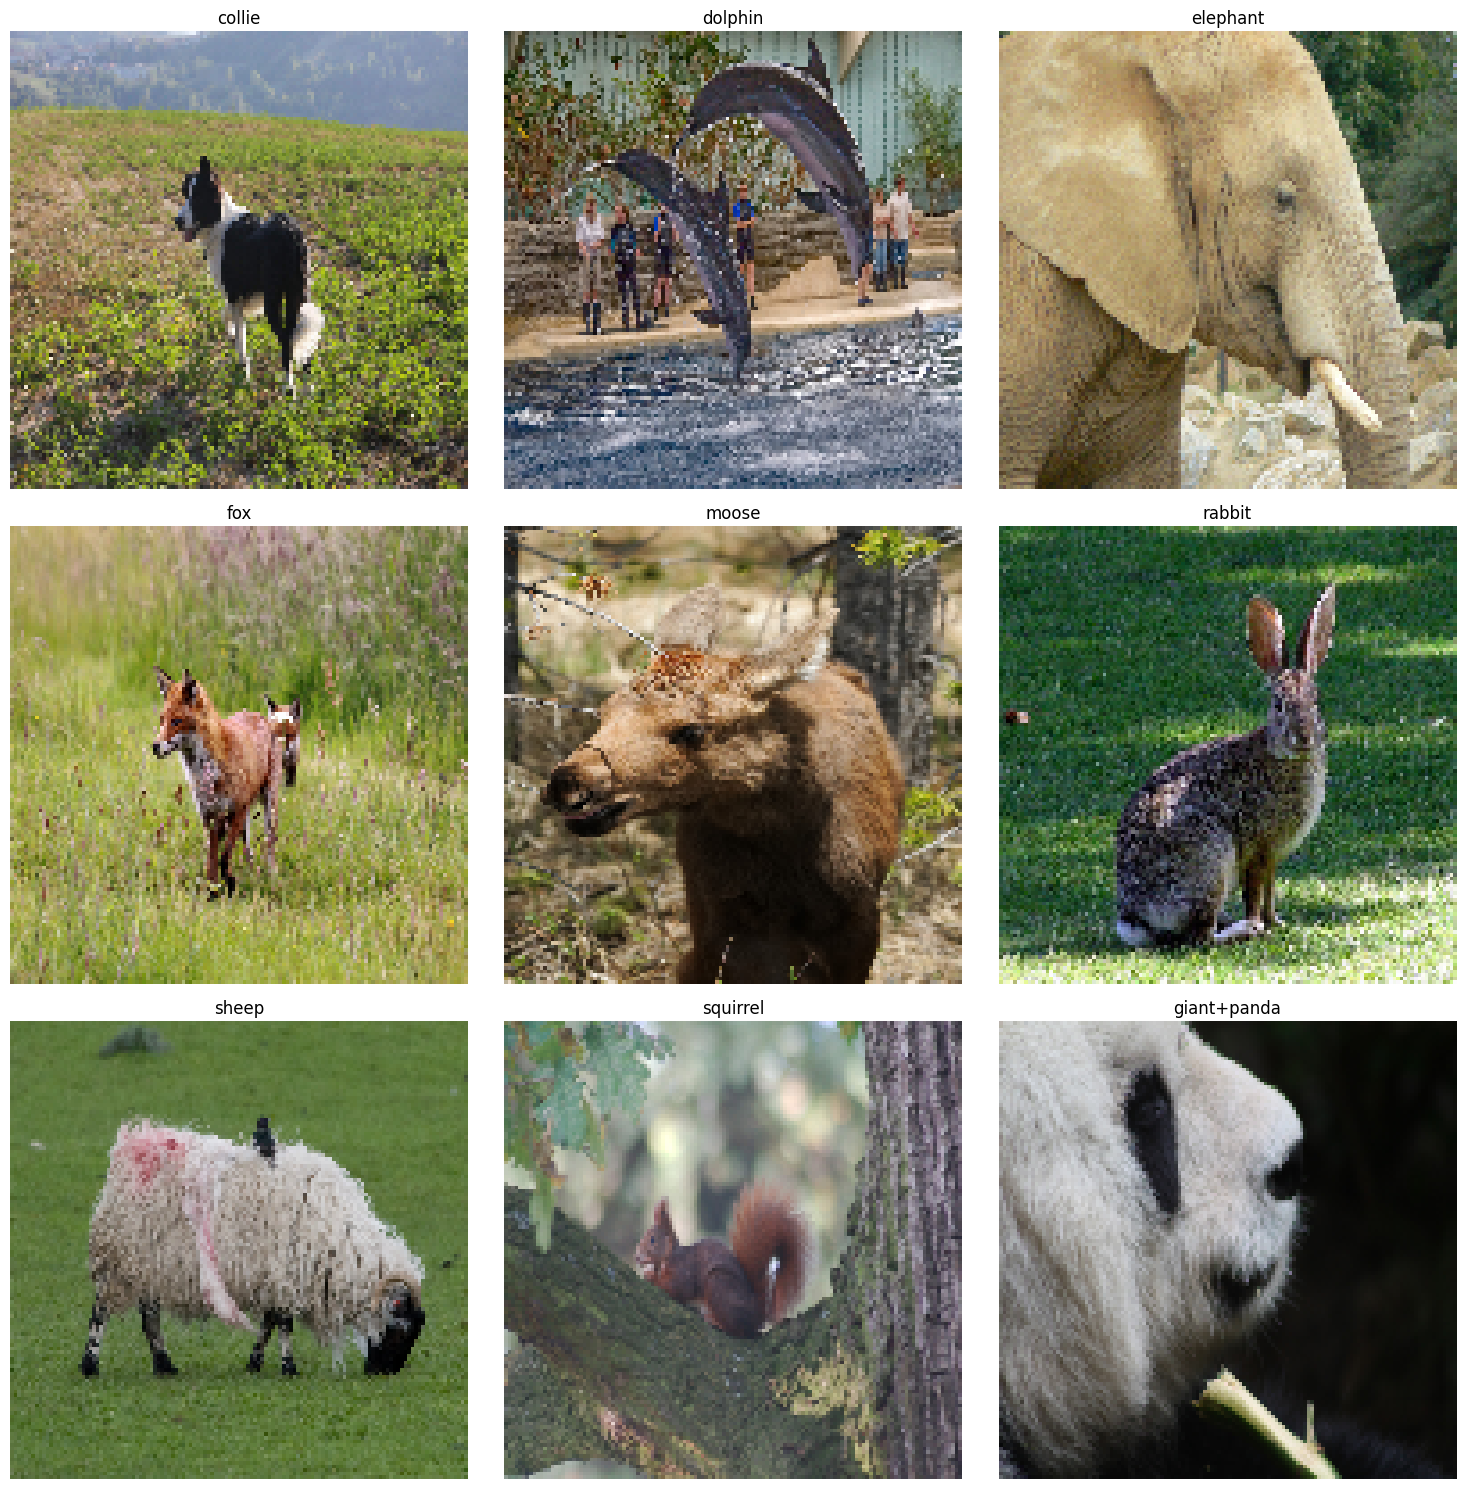

In [4]:
classes_np = np.array(classes)

plt.figure(figsize=(15, 15))

for i in range(9):
    # Her sınıftan ilk resmi al
    class_indices = np.where(classes_np == i)[0]
    if len(class_indices) > 0:
        sample_index = class_indices[0]
        
        plt.subplot(3, 3, i + 1)
        img_rgb = cv2.cvtColor(images[sample_index].astype(np.uint8), cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        plt.title(f'{animals[i]}')
        plt.axis('off')

plt.tight_layout()
plt.show()


In [5]:
# NumPy dizilerine dönüştür
images = np.array(images, dtype=np.float32)
classes = np.array(classes, dtype=np.int64)

print("\nTüm resimler başarıyla yüklendi.")
print(f"Toplam yüklenen resim sayısı: {len(images)}")
print(f"Sınıf sayısı: {len(np.unique(classes))}")

# Sınıf dağılımını kontrol et
print(f"\nSınıf dağılımı:")
for animal, count in zip(animals, [list(classes).count(i) for i in range(len(animals))]):
    print(f"{animal}: {count}")


Tüm resimler başarıyla yüklendi.
Toplam yüklenen resim sayısı: 6500
Sınıf sayısı: 10

Sınıf dağılımı:
collie: 650
dolphin: 650
elephant: 650
fox: 650
moose: 650
rabbit: 650
sheep: 650
squirrel: 650
giant+panda: 650
polar+bear: 650


# 1. Veri Normalizasyonu

In [6]:
images = images.astype('float32') / 255.0

# 2. X ve y olarak ayırma

In [7]:
X = images
y = classes

# 3. Train-Test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42, 
                                                    stratify=y)

print("Eğitim seti boyutu:", X_train.shape)
print("Test seti boyutu:", X_test.shape)

Eğitim seti boyutu: (4550, 128, 128, 3)
Test seti boyutu: (1950, 128, 128, 3)


# 4. Veri Arttırma (Data Augmentation)

In [9]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)


augmented_images = []
augmented_labels = []

for i in range(len(X_train)):
    img = X_train[i]
    label = y_train[i]
    img = np.expand_dims(img, 0)
    
    # Her görüntü için 5 yeni örnek oluştur
    count = 0
    for batch in datagen.flow(img, batch_size=1):
        augmented_images.append(batch[0])
        augmented_labels.append(label)
        count += 1
        if count >= 5:
            break

# Orijinal ve arttırılmış verileri birleştir
X_train_aug = np.concatenate([X_train, np.array(augmented_images)])
y_train_aug = np.concatenate([y_train, np.array(augmented_labels)])

print("Arttırılmış eğitim seti boyutu:", X_train_aug.shape)

Arttırılmış eğitim seti boyutu: (27300, 128, 128, 3)


# 5. CNN Modelini Oluşturma

In [10]:
model = Sequential()

# İlk Konvolüsyon Bloğu
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# İkinci Konvolüsyon Bloğu
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Üçüncü Konvolüsyon Bloğu
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Yoğun Katmanlar
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(len(np.unique(y)), activation='softmax'))


model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 8,681,258 (33.12 MB)

 Trainable params: 8,679,850 (33.11 MB)

 Non-trainable params: 1,408 (5.50 KB)

# 6. Callbacks

In [11]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)

# 7. Model Eğitimi

In [13]:
history = model.fit(
    X_train_aug, y_train_aug,
    validation_split=0.2, 
    epochs=50,
    batch_size=16,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 36s 19ms/step - accuracy: 0.3227 - loss: 2.1676 - val_accuracy: 0.5178 - val_loss: 1.4254 - learning_rate: 0.0010
Epoch 2/50
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.5254 - loss: 1.3884 - val_accuracy: 0.4429 - val_loss: 2.1735 - learning_rate: 0.0010
Epoch 3/50
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.6296 - loss: 1.0659 - val_accuracy: 0.5234 - val_loss: 1.4363 - learning_rate: 0.0010
Epoch 4/50
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.6866 - loss: 0.9151 - val_accuracy: 0.4495 - val_loss: 2.2965 - learning_rate: 0.0010
Epoch 5/50
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.7386 - loss: 0.7525 - val_accuracy: 0.6546 - val_loss: 1.0331 - learning_rate: 0.0010
Epoch 6/50
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.7870 - loss: 0.6147 - val_accuracy: 0.7185 - val_loss: 0.8333 - learning_rate: 0.0010
Epoch 7/50
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accura

# 8. Eğitim Sonuçlarını Görselleştirme

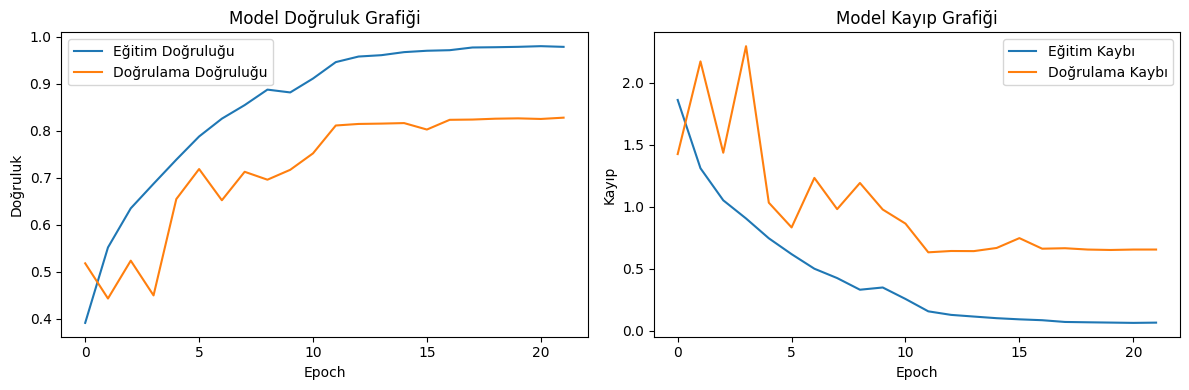

In [14]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluk Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kayıp Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

plt.tight_layout()
plt.show()

# 9. Test Seti Üzerinde Değerlendirme

In [15]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"\nTest seti doğruluğu: {test_accuracy:.4f}")

61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8152 - loss: 0.6927

Test seti doğruluğu: 0.8338


# Modeli ve sınıf etiketini kaydet

In [17]:
# Modeli kaydet
model.save('animal_classifier_model.h5')

# Sınıf etiketlerini kaydet
import json
class_labels = {i: animal for i, animal in enumerate(animals)}
with open('class_labels.json', 'w') as f:
    json.dump(class_labels, f)

# 10. Manipüle Edilmiş Görüntüleri Test Etme
Eğitim Webinarı Kodu Kullandım

In [20]:
# Color Constancy
"""
Global AI Image Processing Bootcamp
Dec 2024
Diclehan and Oguzhan Ulucan
"""

import numpy as np
import cv2


### Fundamental functions
def linearize_image(image):
    """
    Converts an sRGB image to linear RGB assuming the input image is in the range [0, 1]
    """
    return np.where(image <= 0.04045,
                    image / 12.92,
                    ((image + 0.055) / 1.055) ** 2.4)


def linear_to_srgb(image):
    """
    Converts a linear RGB image to sRGB assuming the input image is in the range [0, 1]
    """
    return np.where(image <= 0.0031308,
                    image * 12.92,
                    1.055 * (image ** (1 / 2.4)) - 0.055)


def handle_saturation(image, lower=0.05, upper=0.95):
    """
    Creates a mask for non-saturated pixels (those between `lower` and `upper` thresholds)
    """
    return np.all((image > lower) & (image < upper), axis=-1)



### Color constancy
def estimate_light_source_grey_world(image, mask):
    """
    Estimates the light source based on the Grey World assumption, using valid pixels from the mask
    """
    valid_pixels = image[mask]
    avg_color = np.mean(valid_pixels, axis=0)
    return avg_color / np.linalg.norm(avg_color)


def correct_colors(image, light_source):
    """
    Corrects the colors of the image by applying white balance using the estimated light source
    """
    return image * (1.0 / light_source)


def manipulate_light_source(image, light_color):
    """
    Simulates color manipulation under a different light source

    Args:
    - image: The input image (sRGB, [0, 1])
    - light_color: The light source color (unit norm RGB vector)

    Returns:
    - Manipulated image (sRGB, [0, 1])
    """
    # Step 1: Linearize the image
    linear_image = linearize_image(image)

    # Step 2: Apply the light source (multiplying the linear image by the light color)
    manipulated_image = linear_image * light_color

    # Step 3: Convert the manipulated image back to sRGB
    manipulated_srgb = linear_to_srgb(manipulated_image)

    return np.clip(manipulated_srgb, 0, 1) 


def process_and_white_balance(image):
    """
    Applies white balance using both the Grey World and Max RGB methods
    Returns both corrected images in sRGB format
    """
    linear_image = linearize_image(image)
    valid_mask = handle_saturation(linear_image)

    # Light source estimations
    grey_world_light = estimate_light_source_grey_world(linear_image, valid_mask)

    # Color correction using both light sources
    corrected_grey_world = correct_colors(linear_image, grey_world_light)

    # Convert back to sRGB
    srgb_grey_world = linear_to_srgb(corrected_grey_world)

    # Clip and return
    return np.clip(srgb_grey_world, 0, 1)


# Light sources for color manipulation
def get_light_sources():
    """
    Returns a set of light sources for image manipulation
    """
    purplish_light = np.array([0.82, 0.15, 0.89]) / np.linalg.norm([0.82, 0.15, 0.89])
    yellowish_light = np.array([0.96, 0.24, 0.11]) / np.linalg.norm([0.96, 0.24, 0.11])
    greenish_light = np.array([0.11, 0.98, 0.12]) / np.linalg.norm([0.11, 0.98, 0.12])
    return purplish_light, yellowish_light, greenish_light


def get_wb_images(image):
    """
    Process and white balance the image
    """
    
    srgb_grey_world = process_and_white_balance(image)

    # Save the white-balanced images
    #cv2.imwrite('white_balanced_grey_world.jpg', cv2.cvtColor((srgb_grey_world*255).astype(np.uint8), cv2.COLOR_RGB2BGR))
    return srgb_grey_world


def get_manipulated_images(image):
    """
    Get manipulated images by applying color vectors
    """
    
    # Get the color vectors
    purplish_light, orangish_light, greenish_light = get_light_sources()

    # Manipulate the images under different light sources
    manipulated_purplish = manipulate_light_source(image, purplish_light)
    manipulated_orangish = manipulate_light_source(image, orangish_light)
    manipulated_greenish = manipulate_light_source(image, greenish_light)

    # Save the manipulated images
    #cv2.imwrite('manipulated_purplish.jpg', cv2.cvtColor((manipulated_purplish*255).astype(np.uint8), cv2.COLOR_RGB2BGR))
    #cv2.imwrite('manipulated_orangish.jpg', cv2.cvtColor((manipulated_orangish*255).astype(np.uint8), cv2.COLOR_RGB2BGR))
    #cv2.imwrite('manipulated_greenish.jpg', cv2.cvtColor((manipulated_greenish*255).astype(np.uint8), cv2.COLOR_RGB2BGR))
    return manipulated_purplish, manipulated_orangish, manipulated_greenish


In [32]:
def evaluate_model(model, images, labels):

    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    accuracy = np.mean(predicted_labels == labels)
    return accuracy
    
manipulated_images = []
for image in X_test:
  manipulated_purplish, manipulated_orangish, manipulated_greenish = get_manipulated_images(image)
  manipulated_images.extend([manipulated_purplish, manipulated_orangish, manipulated_greenish])
manipulated_images = np.array(manipulated_images)
manipulated_labels = np.repeat(y_test, 3) # Etiketleri her manipülasyon için tekrarlayın


manipulated_accuracy = evaluate_model(model, manipulated_images, manipulated_labels)
print(f"Manipüle Edilmiş Görüntüler Başarısı: {manipulated_accuracy}")

183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
Manipüle Edilmiş Görüntüler Başarısı: 0.21162393162393162


In [36]:
white_balanced_images = []
for image in X_test:
    white_balanced_image = get_wb_images(image)
    white_balanced_images.append(white_balanced_image)
white_balanced_images = np.array(white_balanced_images)


white_balanced_accuracy = evaluate_model(model, white_balanced_images, y_test)
print(f"Renk Sabitliği Uygulanmış Görüntüler Başarısı: {white_balanced_accuracy}")

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Renk Sabitliği Uygulanmış Görüntüler Başarısı: 0.7938461538461539


In [41]:
# Sonuçları karşılaştır
print(f"Orijinal test seti başarı oranı: {test_accuracy * 100:.2f}%")
print(f"Manipüle edilmiş görüntülerle test başarı oranı: {manipulated_accuracy * 100:.2f}%")
print(f"Renk sabitliği uygulanmış görüntülerle test başarı oranı: {white_balanced_accuracy * 100:.2f}% \n")

Orijinal test seti başarı oranı: 83.38%
Manipüle edilmiş görüntülerle test başarı oranı: 21.16%
Renk sabitliği uygulanmış görüntülerle test başarı oranı: 79.38% 



# 11. Model Performansı Değerlendirmesi

Bu projede, bir CNN modeli kullanılarak 10 farklı hayvan türünün sınıflandırılması amaçlanmıştır. Modelin performansı, üç farklı senaryo altında değerlendirilmiştir: orijinal test verileri, manipüle edilmiş test verileri ve renk sabitliği uygulanmış test verileri.  Aşağıda, her senaryo için elde edilen başarı oranları ve bunların yorumları yer almaktadır.

**1. Orijinal Test Verileri:**

* **Başarı Oranı:** %83.38
* **Yorum:** Model, orijinal test verileri üzerinde yeterli bir performans sergilemiştir.  Bu, modelin eğitim verilerinden öğrendiği özellikleri genelleştirme yeteneğinin iyi olduğunu göstermektedir.

**2. Manipüle Edilmiş Test Verileri:**

* **Başarı Oranı:** %21.16
* **Yorum:**  Manipüle edilmiş görüntüler (farklı ışıklandırma koşulları altında), modelin performansında ciddi bir düşüşe neden olmuştur. Bu düşüş, modelin farklı ışıklandırma koşullarına karşı hassas olduğunu ve bu tür değişikliklere adapte olmakta zorlandığını göstermektedir. Modelin eğitimi sırasında veri çeşitliliğini artırmak ve farklı ışıklandırma koşullarını içeren görüntüler kullanmak, bu sorunu hafifletmeye yardımcı olabilir.

**3. Renk Sabitliği Uygulanmış Test Verileri:**

* **Başarı Oranı:** %79.38
* **Yorum:** Renk sabitliği algoritmasının uygulanması, manipüle edilmiş görüntülerdeki performans düşüşünü önemli ölçüde telafi etmiştir.  Bu, renk sabitliğinin, modelin farklı ışıklandırma koşullarına karşı daha robust hale gelmesine yardımcı olduğunu göstermektedir.  %79.38'lik başarı oranı, orijinal test verilerindeki başarı oranına (%83.38) oldukça yakındır. Bu da renk sabitliği algoritmasının etkinliğini kanıtlamaktadır.


**Sonuç ve Öneriler:**

Model, orijinal test verilerinde iyi bir performans gösterse de, farklı ışıklandırma koşulları altında performansında önemli bir düşüş gözlemlenmiştir. Renk sabitliği algoritması, bu düşüşü büyük ölçüde telafi etmiş olsa da, modelin robustluğunu daha da artırmak için ek adımlar atılabilir.

Önerilen iyileştirmeler:

* **Veri Artırma:** Eğitim verilerine farklı ışıklandırma koşullarını simüle eden görüntüler eklenerek modelin daha robust hale getirilmesi.
* **Farklı Renk Sabitliği Algoritmaları:** Farklı renk sabitliği algoritmaları denenerek en uygun algoritmanın belirlenmesi.
* **Model Mimarisi:** Modelin mimarisinde değişiklikler yapılarak farklı ışıklandırma koşullarına karşı daha az hassas hale getirilmesi.


Bu proje, gerçek dünya koşullarında görüntü sınıflandırma modellerinin karşılaşabileceği zorlukları ve bu zorlukların üstesinden gelmek için kullanılabilecek yöntemleri göstermektedir.